# CNN + LSTM Hypermodel V3
The third revision of this hypermodel introduces all the hyperparameters availble for the CNN & LSTM image captioning model to the tuner so that the optimal one can be found.

### Hyperparameters Tuned 
1. CNN feature extractor
2. Dimension of the LSTM and Image dense
3. Dimension of the Dense layer before the final prediction
4. Embedding dimension
5. Regularizer type and factor
6. Layer normlization
7. Dropout factor 

In [1]:
# general imports
import tensorflow as tf
import os
import keras
from pickle import load
from math import ceil
from numpy.random import choice

# model imports
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, Embedding, Add, LayerNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
from keras.losses import SparseCategoricalCrossentropy
from keras.regularizers import L1, L2
from keras.utils import plot_model

# pre-trained cnn imports 
from keras.applications import VGG16, VGG19, ResNet50, ResNet152, ResNet50V2, ResNet152V2, InceptionV3, InceptionResNetV2, EfficientNetB0, EfficientNetB1, EfficientNetB2, NASNetMobile, ConvNeXtTiny, ConvNeXtBase, DenseNet121, DenseNet201   # type: ignore
from keras.applications import vgg16, vgg19, resnet, resnet_v2, inception_v3, inception_resnet_v2, efficientnet, nasnet, convnext, densenet

# tuning imports
from keras_tuner import HyperModel, BayesianOptimization
from keras.initializers import HeUniform, Orthogonal, GlorotUniform

# custom function imports
from functions.dataset_loading import load_flicker8k_split
from functions.text_processing import create_vocab_mappings
from functions.image_processing import load_image, display_image
from functions.training import data_generator
from functions.model_evaluation import generate_and_evaluate_caption

keras.mixed_precision.set_global_policy("mixed_float16")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [4]:
SEQ_LENGTH = 20
BATCH_SIZE = 64
VOCAB_SIZE = 4096

In [5]:
# Loading Flicker8K processed data from folder 
DIR = 'preprocessed_data/flicker8k/'

with open(DIR + 'caption_map.pkl', 'rb') as file:
    caption_map = load(file)
    
with open(DIR + 'feature_map.pkl', 'rb') as file:
    feature_map = load(file)
    
with open(DIR + 'vocab.pkl', 'rb') as file:
    vocab = load(file)
    
train_images, val_images, test_images = load_flicker8k_split()

STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

In [6]:
# Extracting the image data for train and validation images
train_images, val_images, test_images = load_flicker8k_split()

tuning_train_images = train_images[:500]
tuning_val_images = val_images[:100]

train_image_data, val_image_data, test_image_data = {}, {}, {}

for img in train_images:
    image_path = os.path.join('datasets/flicker8k/Flicker8k_images', img)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    train_image_data[img] = image_data
    
for img in val_images:
    image_path = os.path.join('datasets/flicker8k/Flicker8k_images', img)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    val_image_data[img] = image_data
    
for img in test_images:
    image_path = os.path.join('datasets/flicker8k/Flicker8k_images', img)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    test_image_data[img] = image_data

In [5]:
# Creating tuning training and validation datasets
tuning_train_data = data_generator(tuning_train_images, caption_map, train_image_data, BATCH_SIZE)
tuning_val_data = data_generator(tuning_val_images, caption_map, val_image_data, BATCH_SIZE)

In [32]:
class ImageCaptioningHyperModel(HyperModel):
    def __init__(self, seq_len, vocab_size, image_shape= (224, 224, 3), hidden_dim= 1024, dropout= 0.2, seed = 17):
        super().__init__()
        self.image_shape = image_shape
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.dropout = dropout 
        self.seed = seed
        
        self.cnn_configs = {
            'vgg16': (VGG16, vgg16.preprocess_input),
            'vgg19': (VGG19, vgg19.preprocess_input),
            'resnet50': (ResNet50, resnet.preprocess_input),
            'resnet152': (ResNet152, resnet.preprocess_input),
            'resnet50v2': (ResNet50V2, resnet_v2.preprocess_input),
            'resnet152v2': (ResNet152V2, resnet_v2.preprocess_input),
            'inception': (InceptionV3, inception_v3.preprocess_input),
            'inceptionresnet': (InceptionResNetV2, inception_resnet_v2.preprocess_input),
            'efficientb0': (EfficientNetB0, efficientnet.preprocess_input),
            'efficientb1': (EfficientNetB1, efficientnet.preprocess_input),
            'efficientb2': (EfficientNetB2, efficientnet.preprocess_input),
            'nasnetmobile': (NASNetMobile, nasnet.preprocess_input),
            'densenet121': (DenseNet121, densenet.preprocess_input),
            'densenet201': (DenseNet201, densenet.preprocess_input), 
            'convnexttiny': (ConvNeXtTiny, convnext.preprocess_input),
            'convnextbase': (ConvNeXtBase, convnext.preprocess_input)
        }        
                
    def build(self, hp):
        # Pre-trained cnn choice
        cnn_choice = hp.Choice('cnn', list(self.cnn_configs.keys()))
        CNN, preprocess_func = self.cnn_configs[cnn_choice]
        
        feature_extractor = CNN(
            weights='imagenet',
            include_top=False,
            input_shape=self.image_shape,
            pooling='avg'
        )
        feature_extractor.trainable = False
        
        # Embedding choice
        embed_dim = hp.Choice('embed_dim', [100, 200, 300])
        
        with open(DIR + 'embedding_matrix_glove_' + str(embed_dim) + '.pkl', 'rb') as file:
            embedding_matrix = load(file)

        embedding_layer = Embedding(
            self.vocab_size,
            embed_dim,
            input_length=self.seq_len,
            trainable=False,
            weights=[embedding_matrix],
            name='sequence_embedding'
        )
        
        # Regularizer choice
        reg_type = hp.Choice('regularizer_type', values=['none', 'l1', 'l2'])
        reg_factor = hp.Choice('regularization_factor', values=[1e-6, 1e-4, 1e-2])
        
        if reg_type == 'l1':
            regularizer = L1(reg_factor) 
        elif reg_type == 'l2':
            regularizer = L2(reg_factor) 
        else: 
            regularizer = None
        
        # Other hyperparmeter choices
        hidden_dim = hp.Choice('hidden_dim', values = [256, 512, 1024])
        pred_dim = hp.Choice('pred_dim', values = [256, 512, 1024])
        dropout_rate = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
        use_layer_norm = hp.Boolean('use_layer_norm')
        learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
                
        # Building the model
        # Image path
        image_input = Input(shape=self.image_shape, name='image_input')
        processed_image = preprocess_func(image_input)
        image_features = feature_extractor(processed_image)        
        image_dropout = Dropout(dropout_rate, name='image_dropout')(image_features)
        x_img = Dense(hidden_dim, activation = 'relu', kernel_initializer= HeUniform(), kernel_regularizer=regularizer, name='image_dense')(image_dropout)    
        if use_layer_norm:
            x_img = LayerNormalization()(x_img) 

        # Sequence path
        caption_input = Input(shape=(self.seq_len,), name='caption_input')
        caption_embedding = embedding_layer(caption_input)
        caption_dropout = Dropout(dropout_rate, name='embedding_dropout')(caption_embedding)
        x_caption = LSTM(hidden_dim, return_sequences=True, kernel_initializer= Orthogonal(), kernel_regularizer=regularizer, recurrent_regularizer=regularizer, name='lstm_layer')(caption_dropout)
        if use_layer_norm:
            x_caption = LayerNormalization()(x_caption)

        # Combining image and sequence data
        merging_layer = Add()([x_img, x_caption])
        merge_dropout = Dropout(dropout_rate)(merging_layer)

        # Prediction layers        
        x_pred = Dense(pred_dim, activation='relu', kernel_initializer= HeUniform(), kernel_regularizer=regularizer)(merge_dropout)
        if use_layer_norm:
            x_pred = LayerNormalization()(x_pred)
        prediction_dropout = Dropout(dropout_rate)(x_pred)
        output = Dense(self.vocab_size, activation='softmax', kernel_initializer= GlorotUniform(), kernel_regularizer=regularizer)(prediction_dropout)
        
        model = Model(inputs = [image_input, caption_input] , outputs = output)       
        model.compile(optimizer= Adam(learning_rate), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
        
        return model


## Tuning the Hypermodel

In [33]:
# Initialize hypermodel
hypermodel = ImageCaptioningHyperModel(SEQ_LENGTH, VOCAB_SIZE)

# Initialize tuner
tuner = BayesianOptimization(
    hypermodel,
    objective="val_loss", 
    max_trials=500,  
    directory="keras_tuning",
    project_name="cnn_lstm_architecture_search_v3.3", 
)

# Initializing tensorborad callback 
tensorboard = TensorBoard(
    log_dir='./tensorboard_logs/architecture_search_v3.3',
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)


Reloading Tuner from keras_tuning\cnn_lstm_architecture_search_v3.3\tuner0.json


In [ ]:
# Searching for optimal solution 
tuner.search(
    tuning_train_data,
    epochs = 3,
    steps_per_epoch=STEPS,
    validation_data=tuning_val_data,
    validation_steps=VAL_STEPS,
    callbacks= [tensorboard],
    verbose=1
)

In [14]:
tuner.results_summary(5)

Results summary
Results in keras_tuning\cnn_lstm_architecture_search_v3.3
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 071 summary
Hyperparameters:
cnn: resnet50
embed_dim: 300
hidden_dim: 1024
pred_dim: 256
dropout: 0.2
regularizer_type: l2
regularization_factor: 1e-06
use_layer_norm: True
learning_rate: 0.001
Score: 2.1621296405792236

Trial 121 summary
Hyperparameters:
cnn: vgg19
embed_dim: 300
hidden_dim: 512
pred_dim: 256
dropout: 0.1
regularizer_type: l2
regularization_factor: 1e-06
use_layer_norm: True
learning_rate: 0.001
Score: 2.1818840503692627

Trial 108 summary
Hyperparameters:
cnn: inceptionresnet
embed_dim: 300
hidden_dim: 1024
pred_dim: 512
dropout: 0.1
regularizer_type: l2
regularization_factor: 1e-06
use_layer_norm: True
learning_rate: 0.0001
Score: 2.186025857925415

Trial 093 summary
Hyperparameters:
cnn: vgg19
embed_dim: 300
hidden_dim: 512
pred_dim: 256
dropout: 0.1
regularizer_type: l2
regularization_factor: 1e-06
use_layer_norm: True


In [ ]:
best_models = tuner.get_best_models(3)

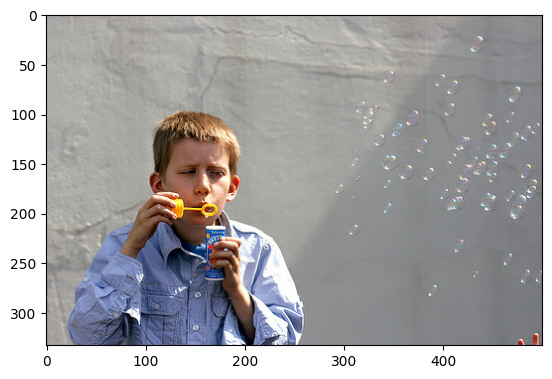

Predicted caption:
a man wearing a white shirt is holding a [UNK]


Predicted caption:
a young girl wearing a pink shirt and a little girl are holding a [UNK]


Predicted caption:
a man is holding a baby is holding a baby


Predicted caption:
a man is holding a baby is holding a baby




In [13]:
# Testing the top three models 

test_image = choice(val_images)
test_features = val_image_data[test_image]
true_captions = caption_map[test_image]

display_image('datasets/flicker8k/flicker8k_images/', test_image)


for model in best_models: 
    generate_and_evaluate_caption(test_features, idx_to_word, model, SEQ_LENGTH) 
    print('\n')
    
selected_trial = tuner.oracle.get_trial('108')
selected_model = tuner.load_model(selected_trial)
generate_and_evaluate_caption(test_features, idx_to_word, selected_model, SEQ_LENGTH) 
print('\n')

In [ ]:
# import pandas as pd

# # Extract trials from the tuner
# trials = tuner.oracle.trials.values()

# # Create a list of dictionaries with relevant information
# trial_data = []
# for trial in trials:
#     trial_data.append({
#         "trial_id": trial.trial_id,
#         "hyperparameters": trial.hyperparameters.values,
#         "score": trial.score
#     })

# # Convert to a DataFrame
# df_results = pd.DataFrame(trial_data)

# # Expand hyperparameters into separate columns (optional)
# df_hyperparams = pd.json_normalize(df_results["hyperparameters"])
# df_results = pd.concat([df_results.drop(columns="hyperparameters"), df_hyperparams], axis=1)

# # Display the DataFrame
# df_results

    trial_id     score           cnn  embed_dim  hidden_dim  pred_dim  \
0        004  2.517452  nasnetmobile        300         256       512   
1        000  2.834047   efficientb0        300         512       256   
2        033  2.238402     inception        300         512       512   
3        002  2.458368   densenet201        100         256       256   
4        028  2.299314   resnet152v2        200         256       512   
..       ...       ...           ...        ...         ...       ...   
118      065  2.242598   efficientb0        300         512       512   
119      088  2.317338    resnet50v2        300        1024       256   
120      091  2.209629         vgg19        300         512       256   
121      074  2.231071     inception        300        1024       256   
122      067  2.341298   resnet152v2        100         256      1024   

     dropout regularizer_type  regularization_factor  use_layer_norm  \
0        0.1               l2               0.00000

In [45]:
csv_filename = "tuner_results.csv"

# Write the DataFrame to a CSV file
df_results.to_csv(csv_filename, index=False)


In [38]:
# Creating tuning training and validation datasets
train_data = data_generator(train_images, caption_map, train_image_data, BATCH_SIZE)
val_data = data_generator(val_images, caption_map, val_image_data, BATCH_SIZE)

In [36]:
best_hp = tuner.get_best_hyperparameters(3)

In [35]:
model_1 = hypermodel.build(best_hp[0])
model_1.fit(
    train_data, 
    epochs = 3,
    steps_per_epoch=STEPS, 
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    # callbacks= [early_stopping],
    verbose=1
)

KeyboardInterrupt: 

In [15]:
model_1.save('saved_models/cnn_lstm_v1')

INFO:tensorflow:Assets written to: saved_models/cnn_lstm_v1\assets


INFO:tensorflow:Assets written to: saved_models/cnn_lstm_v1\assets


In [2]:
model_1 = keras.models.load_model('saved_models/cnn_lstm_v1')

In [39]:
model_2 = hypermodel.build(best_hp[1])
model_2.fit(
    train_data, 
    epochs = 3,
    steps_per_epoch=STEPS, 
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    # callbacks= [early_stopping],
    verbose=1
)

Epoch 1/3
469/469 [==============================] - 46s 90ms/step - loss: 2.3826 - accuracy: 0.5844 - val_loss: 1.9492 - val_accuracy: 0.6206
Epoch 2/3
469/469 [==============================] - 42s 89ms/step - loss: 1.8149 - accuracy: 0.6325 - val_loss: 1.8123 - val_accuracy: 0.6353
Epoch 3/3
469/469 [==============================] - 40s 86ms/step - loss: 1.6579 - accuracy: 0.6463 - val_loss: 1.7502 - val_accuracy: 0.6424


In [ ]:
model_2.save('saved_models/cnn_lstm_v2')

In [ ]:
model_3 = hypermodel.build(best_hp[3])
model_3.fit(
    train_data, 
    epochs = 3,
    steps_per_epoch=STEPS, 
    validation_data=val_data,
    validation_steps=VAL_STEPS,
    # callbacks= [early_stopping],
    verbose=1
)



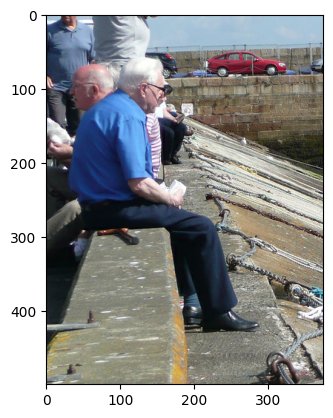

a man is sitting on a dock with a man on a skateboard   0.474468085106383


In [57]:
test_image = choice(val_images)
test_features = val_image_data[test_image]
true_captions = caption_map[test_image]

display_image('datasets/flicker8k/flicker8k_images/', test_image)

caption, true_captions, bleu, meteor = generate_and_evaluate_caption(model_2, test_features, true_captions, idx_to_word, SEQ_LENGTH)
print(caption, ' ', meteor) 

# Training models on coco dataset

In [ ]:
DIR = 'preprocessed_data/coco/'

with open(DIR + 'train_caption_map.pkl', 'rb') as file:
    train_caption_map = load(file)
    
with open(DIR + 'train_feature_map.pkl', 'rb') as file:
    train_feature_map = load(file)

with open(DIR + 'val_caption_map.pkl', 'rb') as file:
    val_caption_map = load(file)
    
with open(DIR + 'val_feature_map.pkl', 'rb') as file:
    val_feature_map = load(file)

with open(DIR + 'embedding_matrix.pkl', 'rb') as file:
    embedding_matrix = load(file)
    
with open(DIR + 'vocab.pkl', 'rb') as file:
    vocab = load(file)
    
train_images = list(train_caption_map.keys())
val_images = list(val_caption_map.keys())

VOCAB_SIZE = len(vocab)
STEPS = ceil(len(train_images) * 5 / BATCH_SIZE)
VAL_STEPS = ceil(len(val_images) * 5 / BATCH_SIZE)

word_to_idx, idx_to_word = create_vocab_mappings(vocab)

train_data = data_generator (train_images, train_caption_map, train_feature_map, BATCH_SIZE)
val_data = data_generator(val_images, val_caption_map, val_feature_map, BATCH_SIZE)

In [ ]:
# Extracting the image data for train and validation images
train_images, val_images, test_images = load_flicker8k_split()

train_images = train_images[:500]
val_images = val_images 

train_image_data, val_image_data, test_image_data = {}, {}, {}

for img in train_images:
    image_path = os.path.join('datasets/coco/train2014', img)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    train_image_data[img] = image_data
    
for img in val_images:
    image_path = os.path.join('datasets/coco/val2014', img)
    image_data = tf.io.read_file(image_path)
    image_data = tf.image.decode_jpeg(image_data, channels=3)
    image_data = tf.image.resize(image_data, [224, 224])
    val_image_data[img] = image_data

## Training outputs 
1. ([0.6405022734089714, 0.4463027082229372, 0.29934462206575563, 0.20871405332039702], 0.4145237453375769) v1
2. ([0.6418743284682035, 0.442693660623719, 0.29415405024196956, 0.20058639500348188], 0.4080181609786798) v2


- ([0.6211531810024086, 0.410840029257982, 0.26646794915971794, 0.1811533502178472], 0.38122496568020725) batch = 64
- ([0.5993318816719131,
  0.3865770367462274,
  0.24482775805037613,
  0.16440581561248588],
 0.3609836026638695) batch = 32
 - ([0.6344307633588684,
  0.4343686956410259,
  0.28711750048084483,
  0.19787981935572438],
 0.3971223813690533) batch = 256
- ([0.6298820729985007,
  0.4312138237301613,
  0.2866155554360642,
  0.19793620298236123],
 0.39902906753744116) previous with more training 
 - ([0.6428814404792379,
  0.4456909514391105,
  0.29858524736881525,
  0.2072303796603672],
 0.4091058296690576) batch = 256, 20 epochs, model saved
 - ([0.6428814404792379,
  0.4456909514391105,
  0.29858524736881525,
  0.2072303796603672],
 0.4091058296690576) previous model with more training 
 - ([0.6390607878281732,
  0.4406290889734613,
  0.2962323225086467,
  0.2063178068601112],
 0.40974129391739644) changed hid dim to 512
 - ([0.6568510950992849,
  0.46559990385495154,
  0.3192417928203884,
  0.22491635004582852],
 0.42799321255907147) added dense layer after concat 

In [ ]:
# decoder.save('models/lstm_decoder_for_cnn_encoder.keras')